Dataset citation: Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

### [Package load]

In [1]:
import torch
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 2.2.2


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.2
GPU 사용 가능 여부: False


In [3]:
# 이걸 해줘야 matplotlib 시행 시 에러가 안 남
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### [For Colab]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

folder = "인공지능 공부" # 상위 directory
project_dir = "[Kaggle] Retinal OCT Images (optical coherence tomography)제목없는 폴더" # 폴더 이름
base_path = Path("/content/drive/MyDrive/")
project_path = base_path / folder / project_dir

os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

### [Setting Hyperparameters]

In [4]:
batch_size = 64
num_epochs = 30
learning_rate = 0.001

### [Dataset & DataLoader]

- ##### 3 channel: Input을 3번 concat -> (3,224,224)

In [5]:
data_dir = '../data/OCT'  # 압축 해제된 데이터셋의 디렉토리 경로

# For Kaggle notebook
#data_dir = '/kaggle/input/kermany2018/OCT2017 /'

In [6]:
class OCTDataset(Dataset):
    def __init__(self, data_dir, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode,'*', '*')))
        self.transform = transform
    
    def __getitem__(self, index):
        data_path = self.all_data[index]
        img = Image.open(data_path)
        if self.transform is not None:
            img = self.transform(img)
        img = img.squeeze()
        img = torch.stack((img, img, img,), dim=0)  # VGG16이 3 channel이라 concat시키기
        name = os.path.basename(data_path)
        if name.startswith('NORMAL'):
            label = 0
        elif name.startswith('CNV'):
            label = 1
        elif name.startswith('DME'):
            label = 2
        elif name.startswith('DRUSEN'):
            label = 3
        return img, label
    
    def __len__(self):
        length = len(self.all_data)
        return length

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ]),
    'val': transforms.Compose([
        transforms.Resize([256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ])
}

In [8]:
train_data = OCTDataset(data_dir=data_dir, mode='train', transform=data_transforms['train'])
val_data = OCTDataset(data_dir=data_dir, mode='val', transform=data_transforms['val'])
test_data = OCTDataset(data_dir=data_dir, mode='test', transform=data_transforms['val'])

In [9]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

In [10]:
train_mean = 0.1881
train_std = 0.1850

### [Model: MobileNet v2]

- https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv2.py

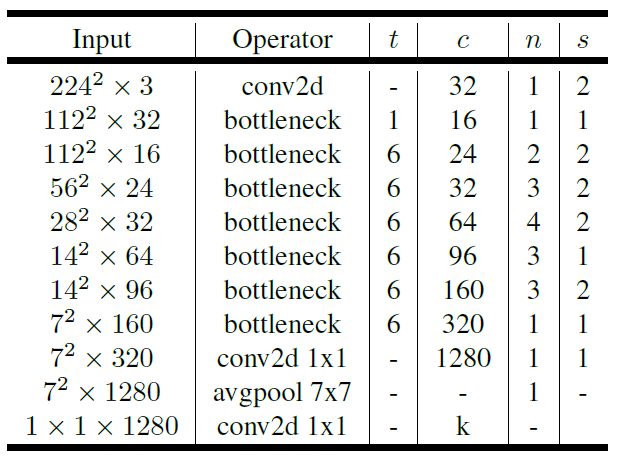

In [15]:
def _make_divisible(v, divisor, min_value = None):
    # 각 channel 수가 나눠질 수 있도록 숫자를 변환시키는 역할
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvNormReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size = 3, groups = 1, stride = 1):
        padding = (kernel_size - 1) // 2
        super(ConvNormReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size = kernel_size, padding = padding, groups=groups, stride = stride),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
            )


class BottleNeck(nn.Module):
    def __init__(self, input_dim, output_dim, stride, expand_ratio=6):
        super().__init__()
        
        self.stride = stride
        
        self.use_res_connect = self.stride == 1 and input_dim == output_dim
            # stride = 1이고 input output channel 수가 같아야 residual connection 사용함
        
        hidden_dim = int(round(input_dim * expand_ratio))
        
        layers = []
        if expand_ratio != 1:
            # Pointwise convolution (expane_ratio가 1이면 의미 없으니 1이 아닐 때만 추가!)
            layers.append(ConvNormReLU(input_dim, hidden_dim, kernel_size=1))
        layers.extend([ConvNormReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),   # depthwise convolution
        nn.Conv2d(hidden_dim, output_dim, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(output_dim)]  # 마지막에는 ReLU가 없음
        )

        self.conv = nn.Sequential(*layers)      # list를 풀어서 sequential로 넣기
        self.output_channel = output_dim
    
    def forward(self, x):
        # use_res_connect가 True인 경우만 residual connection 사용
        # use_res_connect : stride가 1이고 input과 output의 채널 수가 같은 경우 True
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes, alpha=1.0, inverted_residual_setting = None, round_nearest=8, block= None, dropout=0.2):
        # alpha = width multiplier (0, 1] -> Width를 줄여주는 효과 = model을 더 축소시키는 효과
        super(MobileNetV2, self).__init__()
        
        if block is None:
            block = BottleNeck
        
        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
                # t, c, n, s (순서대로) (t: expansion factor, c: output channel, n: 반복, s: stride)
            ]
        
        # 첫 layer 만들기
        input_channel = _make_divisible(input_channel * alpha, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, alpha), round_nearest)
        features = [ConvNormReLU(3, input_channel, stride=2)]

        # 이후 layer 쌓기
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * alpha, round_nearest)
                    # alpha는 output_channel 줄이는 역할 -> 이게 1이 아니면 _make_divisible이 효과를 보게 된다
            # n번 반복
            for i in range(n):
                stride = s if i == 0 else 1     # The first layer of each sequence has a stride s and all others use stride 1.
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        
        # 마지막 몇 개 layer 쌓기
        features.append(ConvNormReLU(input_channel, self.last_channel, kernel_size=1))  # conv2d 1x1

        # nn.Sequential로 feature list를 묶기
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x):
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def forward(self, x):
        return self._forward_impl(x)

In [16]:
mobilenet_v2 = MobileNetV2(num_classes=4).to(device)

In [17]:
mobilenet_v2

MobileNetV2(
  (features): Sequential(
    (0): ConvNormReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): BottleNeck(
      (conv): Sequential(
        (0): ConvNormReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): BottleNeck(
      (conv): Sequential(
        (0): ConvNormReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2

In [18]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 224, 224)))
mobilenet_v2(temp)

tensor([[ 0.0164, -0.0524,  0.1030, -0.3367]], grad_fn=<AddmmBackward0>)

In [19]:
from torchsummary import summary
summary(mobilenet_v2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             320
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
        BottleNeck-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,632
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             960
      BatchNorm2d-14           [-1, 96,

In [20]:
from torchinfo import summary
summary(mobilenet_v2, input_size=(1, 3, 224, 224), col_width=20, depth=100, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)                  Input Shape          Kernel Shape         Output Shape         Param %
MobileNetV2 (MobileNetV2)                          [1, 3, 224, 224]     --                   [1, 4]                    --
├─Sequential (features): 1-1                       [1, 3, 224, 224]     --                   [1, 1280, 7, 7]           --
│    └─ConvNormReLU (0): 2-1                       [1, 3, 224, 224]     --                   [1, 32, 112, 112]         --
│    │    └─Conv2d (0): 3-1                        [1, 3, 224, 224]     [3, 3]               [1, 32, 112, 112]      0.04%
│    │    └─BatchNorm2d (1): 3-2                   [1, 32, 112, 112]    --                   [1, 32, 112, 112]      0.00%
│    │    └─ReLU6 (2): 3-3                         [1, 32, 112, 112]    --                   [1, 32, 112, 112]         --
│    └─BottleNeck (1): 2-2                         [1, 32, 112, 112]    --                   [1, 16, 112, 112]         --
│    │    └─Sequential (

### [Saving checkpoints]

In [21]:
def save_model(model, epoch, optimizer, epoch_loss, val_accuracy, saved_dir):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
    }
    val_accuracy = round(val_accuracy,1)
    file_name = str(f"ckpoint_{epoch+1}_{val_accuracy}%.pt")
    output_path = os.path.join(saved_dir, file_name)
    torch.save(check_point,output_path)

### [Loss tracker]

##### Visdom for local setting

In [ ]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

In [ ]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             )

In [ ]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

##### Tensorboard

In [22]:
logs_base_dir = "./logs/logs_simple"
os.makedirs(logs_base_dir, exist_ok=True)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(logs_base_dir)

### [Defining Train, Val, Test Function]

In [23]:
def train(num_epochs, model, data_loader, criterion, optimizer, scheduler, val_every, device, saved_dir, writer):
    print('Start training..')
    torch.cuda.empty_cache()
    best_loss = 9999999
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    best_epoch = 0
    count = 0
    for epoch in tqdm(range(num_epochs), desc='epoch'):
        # running_loss = 0.0
        for i, (imgs, labels) in tqdm(enumerate(data_loader), desc="in epoch"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Saving train loss
            train_loss_list.append(loss.item())

            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()
            # Saving train accuracy
            train_accuracy_list.append(accuracy)

            if (i+1) % 30 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))
            if (i+1) % 50 == 0:
                writer.add_scalar('Loss/Train', loss, i)
                writer.add_scalar('Accuracy/Train', accuracy, i)
            #if i % 30 == 29:
                #loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
                #running_loss = 0.0
        if (epoch + 1) % val_every == 0:
            avrg_loss, val_accuracy = validation(epoch + 1, model, val_loader, criterion, device)
            # Saving validation loss and accuracy
            val_loss_list.append(avrg_loss)
            writer.add_scalar('Loss/Validation', avrg_loss, epoch+1)
            val_accuracy_list.append(val_accuracy)
            writer.add_scalar('Accuracy/Validation', val_accuracy, epoch+1)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, epoch, optimizer, avrg_loss, val_accuracy, saved_dir)
                count = 0
                best_epoch = epoch + 1
            else:
                count += 1
                print(f'Best epoch does not appear / Previous best epoch:{best_epoch}')
                print(f'A number of epochs remain until early stop: {10-count}')
                if count >= 10:
                    print('Best performance does not occur within 10 epochs. Early stopping!!')
                    scheduler.step()
                    writer.flush()
                    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list
            ''' Only for local setting
            loss_tracker(loss_plt, torch.Tensor([avrg_loss]), torch.Tensor([epoch]))'''
    scheduler.step()
    writer.flush()
    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list

In [24]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch) )
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs,labels)
            
            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        val_accuracy = correct / total * 100
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, val_accuracy, avrg_loss))
    model.train()
    return avrg_loss, val_accuracy

In [25]:
def test(model, data_loader, device):
    print('Start test..')
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        answer_list = []
        pred_list = []
        pred_proba_list = []
        
        for i, (imgs, labels) in tqdm(enumerate(data_loader)):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            pred_probability = F.softmax(outputs, dim=1)
            pred_proba_list.append(pred_probability.tolist())
            
            _, argmax = torch.max(outputs, 1)
            pred_list.append(argmax.tolist())

            total += imgs.size(0)
            correct += (labels == argmax).sum().item()
            
            answer_list.append(labels.tolist())
        
        print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
    model.train()        
    return pred_list, answer_list, pred_proba_list

### [Loss function, Optimizer, Directory for saving]

In [26]:
torch.manual_seed(7777)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(mobilenet_v2.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)

val_every = 1
saved_dir = './saved'

### [Train]

In [ ]:
train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list = train(num_epochs, mobilenet_v2, train_loader, criterion, optimizer, scheduler, val_every, device, saved_dir, writer)

##### Visualizing train loss and accuracy

- With matplotlib in colab setting

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.ylabel('Loss')
plt.plot(train_loss_list, label = 'Train')
plt.plot(val_loss_list, label = 'Validation')
plt.subplot(1,2,2)
plt.ylabel('Accuracy')
plt.plot(train_accuracy_list, label = 'Train')
plt.plot(val_accuracy_list, label = 'Validation')
# plt.savefig('graph.png',facecolor = 'w')
plt.show()

- With Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='./logs/logs_simple'

### [Test]

##### Loading best model

In [ ]:
mobilenet_test = MobileNetV2(num_classes=4).to(device) 
model_path = './saved/.pt'    # .pt 앞에 파일 이름 붙이기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['model_state_dict']
mobilenet_test.load_state_dict(state_dict)
mobilenet_test.eval()

##### Actual test

In [ ]:
with torch.no_grad():
    pred_list, answer_list, pred_proba_list = test(mobilenet_test, test_loader, device)